In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc

# Model training

In this notebook we will compare in a very naive version, LogisticRegression, SVC and DecisionTreeClassifier. We decided to left out other possible models like RandomForest or XGBoost, since we consider the complexity of the data is not so high. But there are lest for future possible analysis.

Since it's only a brief introduction about what the models can do, we won't be perfonming any hyperparameter tuning. Leaving that for a possible autoML in Azure Studio that will be probably better. This phase is only to check and provide a good enough solution for the POC.

In [32]:
x_train = pd.read_csv('w2v_window10_train_data.csv', index_col=0)
y_train = pd.read_csv('y_train.csv').values.ravel()
train_data = {'x': x_train, 'y': y_train}
x_test = pd.read_csv('w2v_window10_test_data.csv', index_col=0)
y_test = pd.read_csv('y_test.csv').values.ravel()

In [36]:
n_rows = 50_000

In [37]:
x_train2 = x_train.iloc[:n_rows]
y_train2 = y_train[:n_rows]
train_data2 = {'x': x_train2, 'y': y_train2}
x_test2 = x_test.iloc[:n_rows]
y_test2 = y_test[:n_rows]

In [21]:
model_dict = {'logreg': LogisticRegression(),
              'svc': SVC(),
              'dectree': DecisionTreeClassifier()}

In [22]:
from sklearn.model_selection import cross_val_score


def generate_cross_scoring_table_from_transf_data(train_data, model_dict, scoring='f1_macro', cv=10):

    all_scores = [cross_val_score(model, train_data['x'], 
                                  train_data['y'], cv=cv, scoring=scoring)
                  for model in model_dict.values()]

    return pd.DataFrame(all_scores, index=model_dict.keys())

In [23]:
def plot_roc_curve(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
def generic_classif_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
    y_proba = model.predict_proba(X_test)[:, 1]
    print('AUC: ', roc_auc_score(y_test, y_proba))
    plot_roc_curve(model, X_test, y_test)

In [38]:
results = generate_cross_scoring_table_from_transf_data(train_data2, model_dict, scoring='f1_macro', cv=3)

results

,0,1,2
logreg,0.820468,0.821788,0.833296
svc,0.825873,0.828021,0.840145
dectree,0.673928,0.669635,0.671198


---------------- Train ----------------
Accuracy:  0.9184717412462371
F1 score:  0.9525829807240245
Confusion matrix:  [[ 30785  17743]
 [  7471 253268]]
AUC:  0.9452196542580354


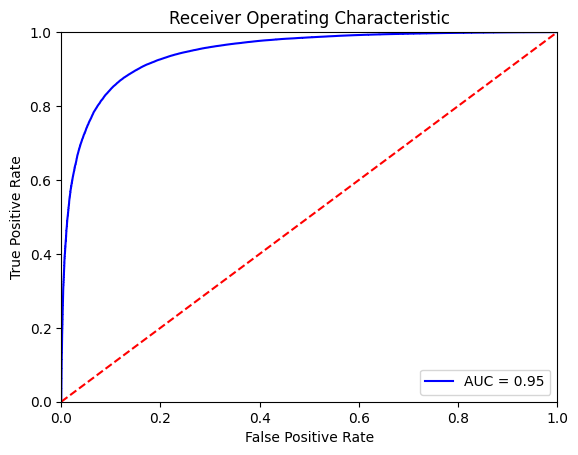

---------------- Test ----------------
Accuracy:  0.9179507851292669
F1 score:  0.9523231548911886
Confusion matrix:  [[ 5376  3173]
 [ 1305 44723]]
AUC:  0.9444867879502683


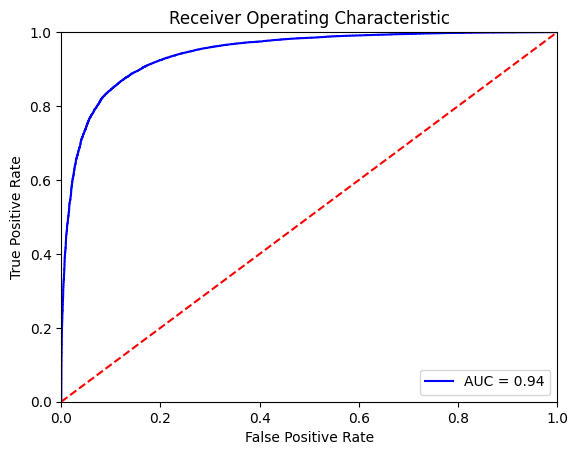

In [34]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('---------------- Train ----------------')
generic_classif_metrics(lr, x_train, y_train)
print('---------------- Test ----------------')
generic_classif_metrics(lr, x_test, y_test)

# Conclusions

To run a version with the full dataset:

- Logreg -> 7s
- DecisionTreeClassifier -> 15min
- SVC without probability on -> 234min

The logistic regression results are good enough for a first approac algorithms. The metrics with subsamples are shown below. However, the trade off training time-results and having to do hyperparameter tuning so the models does not overfit in the case of svc and decision tree with the current time constraints are not feasible. In consequence, they has been discarded for this phase.

In [35]:
print('Subsample 10_000')
results

Subsample 10_000


,0,1,2
logreg,0.802096,0.806404,0.807483
svc,0.784376,0.800923,0.807745
dectree,0.679149,0.652924,0.660564


In [39]:
print('Subsample 50_000')
results

Subsample 50_000


,0,1,2
logreg,0.820468,0.821788,0.833296
svc,0.825873,0.828021,0.840145
dectree,0.673928,0.669635,0.671198
